### Exploratory data analyis of dividend capture strategy
for the S&P 500, starting in 2010

by Flor Lozano-Byrne

In [1]:
import pandas as pd
import dill
from datetime import datetime, timedelta,date
from collections import defaultdict
import numpy as np
import altair as alt

In [2]:
d = dill.load(open('data/d_all_EOD.pkd', 'rb'))
for ticker in d.keys():
    d[ticker] = d[ticker].reset_index(drop = True)
    

### Stocks that currently pay dividends

In [3]:
divs = []
for ticker in d.keys():
    df = d[ticker].copy(deep=True)
    df = df[df.date > datetime(2022,11,1)]
    if [x for x in df['divCash'].values if x>0]:
        divs.append(ticker)
print(len(divs))
divs

397


['BALL',
 'BBWI',
 'TECH',
 'BX',
 'BRO',
 'BG',
 'CPT',
 'COR',
 'CTRA',
 'ELV',
 'EQT',
 'EG',
 'FDS',
 'GEN',
 'HUBB',
 'INVH',
 'KDP',
 'MPWR',
 'NDSN',
 'NXPI',
 'PARA',
 'RVTY',
 'STLD',
 'TRGP',
 'VTRS',
 'VICI',
 'WTW',
 'SPY',
 'ABT',
 'ABBV',
 'ACN',
 'AES',
 'AFL',
 'A',
 'APD',
 'ALB',
 'ARE',
 'ALLE',
 'LNT',
 'ALL',
 'MO',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'ADM',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADP',
 'AVB',
 'AVY',
 'BKR',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BBY',
 'BLK',
 'BWA',
 'BXP',
 'BMY',
 'AVGO',
 'BR',
 'CHRW',
 'CPB',
 'COF',
 'CAH',
 'CARR',
 'CAT',
 'CBOE',
 'CDW',
 'CE',
 'CNP',
 'CF',
 'SCHW',
 'CVX',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'COO',
 'GLW',
 'CTVA',
 'COST',
 'CCI',
 'CSX',
 'CMI',
 'CVS',
 'DHI',
 'DHR',
 'DRI',
 'DE',
 '

### Calculate Maximum Possible Gain using dividend capture strategy
Total gains in the last 13 years, buying at the low the day before the ex-dividend and selling at the high the day after the ex-dividend

In [4]:
def record_gains(startdate = datetime(2010,1,1), max_gain = True):
    dicts = []
    for ticker in divs:
        gain_ct = 0
        loss_ct = 0
        gain_tot = 0
        loss_tot = 0
        net = 0
        df = d[ticker]
        df = df[df.date > startdate]
        df1 = df[df['divCash']>0]
        for index, row in df1.iterrows():
            df2 = df.loc[index - 1:index + 1]
            if len(df2) != 3:
                print('incorrect dataframe length: {} for ticker {}'.format(len(df2),ticker))
                continue
            if max_gain:
                change = df2.high.values[2] - df2.low.values[0]
            else:
                highs = df2.high.values
                lows = df2.low.values
                change = (highs[2] - highs[0] - lows[2] + lows[0])/2
            div = df2.divCash.values[1]
            gain = change + div
            if gain > 0:
                gain_ct +=1
                gain_tot += gain
            else:
                loss_ct +=1
                loss_tot += gain
            net += gain
        dicts.append({'ticker':ticker
                  , 'gain_ct': gain_ct
                 , 'gain_tot': gain_tot
                 , 'loss_ct': loss_ct
                 , 'loss_tot': loss_tot
                 , 'net': net})
    return pd.DataFrame(dicts).sort_values('net').reset_index(drop=True)

max_gains = record_gains()
max_gains

incorrect dataframe length: 2 for ticker AMP
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker C
incorrect dataframe length: 2 for ticker CMCSA
incorrect dataframe length: 2 for ticker ETN
incorrect dataframe length: 2 for ticker GL
incorrect dataframe length: 2 for ticker JPM
incorrect dataframe length: 2 for ticker KHC


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,KVUE,1,0.26000,0,0.0000,0.26000
1,VTRS,8,1.70250,2,-0.4750,1.22750
2,LH,4,6.25000,2,-4.2500,2.00000
3,GEHC,3,2.66330,0,0.0000,2.66330
4,T,8,3.65440,4,-0.4885,3.16590
...,...,...,...,...,...,...
392,MA,49,355.40710,7,-5.8950,349.51210
393,GWW,50,408.27600,5,-19.1740,389.10200
394,EQIX,34,424.98684,3,-29.1811,395.80574
395,LRCX,33,469.69790,5,-32.8225,436.87540


In [5]:
max_gains[max_gains.gain_ct<max_gains.loss_ct]


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net


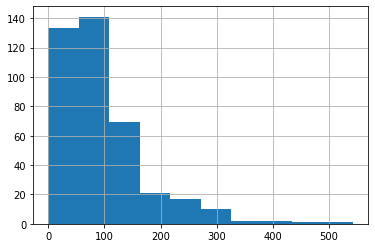

In [6]:
max_gains.net.hist()

### Calculate S&P gains with buy and hold

In [7]:
STARTDATE = datetime(2022,10,26)

In [8]:
### Holding SPY, buying at the close, final value at the close
def calc_spy():
    n_shares = 100
    df = d['SPY'][d['SPY'].date > STARTDATE]
    entry = n_shares * df.iloc[0].adjClose
    print('Original Investment: {}'.format(entry))
    exit = n_shares * df.iloc[-1].adjClose
    profit = exit - entry
    print('Profit: {}%'.format(profit/entry*100))
    return entry
orig_invest = calc_spy()

Original Investment: 37403.19273072
Profit: 16.21735158533145%


### Find dividend payout schedule

In [9]:
def create_dc_sched(startdate, max_gain):
    dicts = []
    df_divs = pd.DataFrame()
    for ticker in divs:
        gain_tot = 0
        loss_tot = 0
        net = 0
        df = d[ticker]
        df = df[df.date > startdate]
        df1 = df[df['divCash']>0]
        df1['ticker'] = ticker
        df_divs =df_divs.append(df1)
    return df_divs.sort_values('date')
        
df_divs = create_dc_sched(STARTDATE, True)

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

### Run trading simulations of past year trades

In [10]:
### Too many each day, need to choose
df_divs

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,ticker
658,2022-10-27,37.88,38.5900,37.530,38.05,7529894,37.252137,37.950369,36.907938,37.419319,7529894,0.150,1.0,CARR
3227,2022-10-27,496.54,503.0100,494.140,499.81,1576567,492.807491,499.228856,490.425532,496.052910,1576567,0.900,1.0,COST
3228,2022-10-28,54.38,54.4850,51.920,51.96,1063284,53.179051,53.281732,50.773379,50.812495,1063284,0.300,1.0,AOS
3228,2022-10-28,82.22,82.2950,79.510,80.27,7816061,79.167709,79.239925,76.558314,77.290100,7816061,0.775,1.0,MS
3228,2022-10-28,96.10,96.3750,93.660,94.49,858656,93.809202,94.077647,91.427366,92.237581,858656,0.700,1.0,CE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,2023-11-02,555.97,559.5100,552.010,556.50,2100573,555.970000,559.510000,552.010000,556.500000,2100573,1.020,1.0,COST
1595,2023-11-03,35.19,35.5400,34.945,35.53,5519138,35.190000,35.540000,34.945000,35.530000,5519138,0.200,1.0,BKR
3483,2023-11-03,335.74,340.2600,334.250,334.29,708067,335.740000,340.260000,334.250000,334.290000,708067,1.350,1.0,AMP
3483,2023-11-03,214.79,219.5399,214.715,218.71,1852921,214.790000,219.539900,214.715000,218.710000,1852921,0.860,1.0,ETN


#### 1. Using ideal entry and exit prices (high -low)

In [11]:
### For each day, choose the ticker with the highest historical gains
def trades(start_amount, max_gain=True):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    d_trades = defaultdict(list)
    d_trade_dates = {}
    for date in df_divs.date.unique():
        if curr_avail_index > 2:
            curr_avail_index = 0
        df1 = df_divs[df_divs.date == date]
        tickers = df1.ticker.values
        d_indexes ={}
        for ticker in tickers:
            d_indexes[ticker] = max_gains[max_gains.ticker == ticker].index[0]    
        selected_ticker = sorted([x for x in d_indexes.items()], key=lambda x:x[1], reverse=True)[0][0]
        df2 = d[selected_ticker]
        idx = df2[df2.date == date].index[0]
        df2 = df2.loc[idx - 1:idx + 1]
        if len(df2) == 3:
            d_trades[selected_ticker].append(date)
            d_trade_dates[date] = selected_ticker
            if max_gain:
                entry_price = df2.low.values[0]
                gain = df2.high.values[2] - entry_price + df2.divCash.values[1]
            else:
                highs = df2.high.values
                lows = df2.low.values
                entry_price = (highs[0] + lows[0]) / 2
                gain = (highs[2] + lows[2]) / 2 - entry_price + df2.divCash.values[1]
            n_shares = avail_amts[curr_avail_index] // entry_price
            gain *= n_shares
            avail_amts[curr_avail_index] += gain
            total += gain
            #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
            #print(avail_amts, sum(avail_amts))
            curr_avail_index += 1
    print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    #if max_gain:
    #    dill.dump(d_trades,open('data/d_trades.pkd','wb'))
    #    dill.dump(d_trade_dates,open('data/d_trade_dates.pkd','wb'))
    return d_trades,d_trade_dates

d_trades,d_trade_dates = trades(orig_invest)

Total gains: 189254.33683600012
Percent return: 505.98444415832364%


In [13]:
### For each day, choose the ticker with the highest historical gains
def trades(start_amount):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    d_trades = defaultdict(list)
    d_trade_dates = {}
    l_temp = []
    for date in df_divs.date.unique():
        if curr_avail_index > 2:
            curr_avail_index = 0
        df1 = df_divs[df_divs.date == date]
        tickers = df1.ticker.values
        d_indexes ={}
        for ticker in tickers:
            d_indexes[ticker] = max_gains[max_gains.ticker == ticker].index[0]    
        selected_ticker = sorted([x for x in d_indexes.items()], key=lambda x:x[1], reverse=True)[0][0]
        df2 = d[selected_ticker]
        idx = df2[df2.date == date].index[0]
        df2 = df2.loc[idx - 1:idx + 1]
        if len(df2) == 3:
            date = datetime.strptime(str(date)[:10],'%Y-%m-%d')
            d_trades[selected_ticker].append(date)
            d_trade_dates[date] = selected_ticker

            entry_price = df2.low.values[0]
            div = df2.divCash.values[1]
            gain = df2.high.values[2] - entry_price + div
            
            n_shares = avail_amts[curr_avail_index] // entry_price
            gain *= n_shares
            avail_amts[curr_avail_index] += gain
            total += gain
            
            curr_avail_index += 1
            
            l_temp.append({'date':date, 'ticker':selected_ticker,'dividend':div
                      ,'low':entry_price, 'high':df2.high.values[2],'profit':gain})
            
    print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))

    dill.dump(d_trades,open('data/d_trades_optim.pkd','wb'))
    dill.dump(d_trade_dates,open('data/d_trade_dates_optim.pkd','wb'))
    return pd.DataFrame(l_temp),d_trades,d_trade_dates 

df_ideal,d_trades,d_trade_dates = trades(orig_invest)
df_ideal

Total gains: 189254.33683600012
Percent return: 505.98444415832364%


,date,ticker,dividend,low,high,profit
0,2022-10-27,COST,0.900,495.690,512.8200,450.750
1,2022-10-28,CE,0.700,95.600,96.8300,250.900
2,2022-10-31,AON,0.560,273.025,286.5662,634.554
3,2022-11-01,MKTX,0.700,241.720,238.9200,-111.300
4,2022-11-02,CAG,0.330,36.320,36.0950,36.750
...,...,...,...,...,...,...
228,2023-10-27,CE,0.700,113.180,116.3300,2737.350
229,2023-10-30,TXN,1.300,142.350,143.0400,843.760
230,2023-10-31,AON,0.615,302.310,312.8700,2771.400
231,2023-11-01,CAG,0.350,27.205,27.7000,2584.010


### Create training dataset

In [12]:
N_PRIOR_DAYS = 251

In [13]:
def adjust_splits(df):
    df = df.reset_index(drop = True)
    splits = [(datetime.strptime(str(x[0])[:10],'%Y-%m-%d'),x[1]) for x in df[df.splitFactor != 1][['date','splitFactor']].to_records(index=False)]
    df = df[['date','close','high','low']].set_index('date')
    for date, factor in splits:
        df.loc[df.index < date] = df.loc[df.index < date] / factor
    return df

d_dfs = defaultdict(dict)
for ticker, dates in d_trades.items():
    df = adjust_splits(d[ticker])
    dates = [datetime.strptime(str(x)[:10],'%Y-%m-%d') for x in dates]
    for date in dates:
        df1 = df.loc[df.index <= date][-N_PRIOR_DAYS:]
        if len(df1) >= N_PRIOR_DAYS:
            d_dfs[ticker][date] = df1
#dill.dump(d_dfs,open('data/d_dfs.pkd','wb'))

### Train ARIMA models and get predictions

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

def get_model_predict():
    d_predictions = defaultdict(dict)
    for ticker, dates in d_dfs.items():
        for date, df in dates.items():
            params_low = auto_arima(df.low).order
            params_high = auto_arima(df.high).order
            d_temp_models = {}
            d_temp_predict = {}
            d_temp_models['low'] = ARIMA(df['low'].values[:-2], order=params_low).fit()
            d_temp_models['high'] = ARIMA(df['high'].values, order=params_high).fit()
            d_temp_models['estimated_high'] = ARIMA(df['high'].values[:-2], order=params_high).fit()
            
            d_temp_predict['estimated_high'] = d_temp_models['estimated_high'].predict(start=len(df)-2,end=len(df))[-1]
            d_temp_predict['low'] = d_temp_models['low'].predict(start=len(df)-2,end=len(df)-2)[0]
            d_temp_predict['high'] = d_temp_models['high'].predict(start=len(df),end=len(df))[0]
            
            d_predictions[ticker][date] = d_temp_predict
            print(ticker,date)
            #print(params_low,params_high)
            #print(df.tail(3))
            #print(d_temp_predict)
            dill.dump(d_predictions,open('data/arima_predictions.pkd','wb'))
            
get_model_predict()

COST 2022-10-27 00:00:00
COST 2023-02-02 00:00:00
COST 2023-05-04 00:00:00
COST 2023-08-24 00:00:00
COST 2023-11-02 00:00:00
CE 2022-10-28 00:00:00
CE 2023-07-28 00:00:00
CE 2023-10-27 00:00:00
AON 2022-10-31 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AON 2023-01-31 00:00:00
AON 2023-04-28 00:00:00
AON 2023-07-31 00:00:00
AON 2023-10-31 00:00:00
MKTX 2022-11-01 00:00:00
MKTX 2023-02-07 00:00:00
MKTX 2023-05-09 00:00:00
MKTX 2023-08-01 00:00:00
CAG 2022-11-02 00:00:00
CAG 2023-11-01 00:00:00
NSC 2022-11-03 00:00:00
NSC 2023-08-03 00:00:00
AMP 2022-11-04 00:00:00
AMP 2023-02-09 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AMP 2023-08-04 00:00:00
AWK 2022-11-07 00:00:00
AWK 2023-02-06 00:00:00
AWK 2023-05-08 00:00:00
AWK 2023-08-07 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


WST 2022-11-08 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


WST 2023-01-24 00:00:00
WST 2023-04-25 00:00:00
WST 2023-07-25 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


POOL 2022-11-09 00:00:00
POOL 2023-05-16 00:00:00
POOL 2023-08-09 00:00:00
GWW 2022-11-10 00:00:00
GWW 2023-02-10 00:00:00
GWW 2023-05-05 00:00:00
GWW 2023-08-11 00:00:00
TFX 2022-11-14 00:00:00
TFX 2023-03-02 00:00:00
TFX 2023-08-14 00:00:00
EQIX 2022-11-15 00:00:00
EQIX 2023-05-23 00:00:00
EQIX 2023-08-22 00:00:00
AMGN 2022-11-16 00:00:00
AMGN 2023-05-17 00:00:00
WHR 2022-11-17 00:00:00
WHR 2023-05-18 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


TSCO 2022-11-18 00:00:00
SWKS 2022-11-21 00:00:00
SWKS 2023-08-28 00:00:00
EG 2022-11-22 00:00:00
EG 2023-03-15 00:00:00
EG 2023-09-18 00:00:00
HII 2022-11-23 00:00:00
NOC 2022-11-25 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


NOC 2023-02-24 00:00:00
NOC 2023-05-26 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NOC 2023-08-25 00:00:00
KEY 2022-11-28 00:00:00
FDS 2022-11-29 00:00:00
FDS 2023-02-27 00:00:00
FDS 2023-05-30 00:00:00
FDS 2023-08-30 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GS 2022-11-30 00:00:00
GS 2023-03-01 00:00:00
GS 2023-05-31 00:00:00
TT 2022-12-01 00:00:00
TT 2023-06-01 00:00:00
UNH 2022-12-02 00:00:00
UNH 2023-03-10 00:00:00
UNH 2023-06-15 00:00:00
UNH 2023-09-08 00:00:00
CI 2022-12-05 00:00:00
BLK 2022-12-06 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BLK 2023-03-06 00:00:00
BLK 2023-06-07 00:00:00
BLK 2023-09-07 00:00:00
NEM 2022-12-07 00:00:00
CME 2022-12-08 00:00:00
CME 2022-12-27 00:00:00
CME 2023-03-09 00:00:00
CME 2023-06-08 00:00:00
FDX 2022-12-09 00:00:00
FDX 2023-06-09 00:00:00
BBY 2022-12-12 00:00:00
BBY 2023-03-22 00:00:00
LRCX 2022-12-13 00:00:00
LRCX 2023-03-14 00:00:00
LRCX 2023-06-13 00:00:00
LRCX 2023-09-12 00:00:00
TMO 2022-12-14 00:00:00
TMO 2023-06-14 00:00:00
TMO 2023-09-14 00:00:00
CB 2022-12-15 00:00:00
CB 2023-03-16 00:00:00
UNP 2022-12-16 00:00:00
AVGO 2022-12-19 00:00:00
AVGO 2023-03-21 00:00:00
AVGO 2023-06-21 00:00:00
AVGO 2023-09-20 00:00:00
STX 2022-12-20 00:00:00
STX 2023-06-20 00:00:00
PM 2022-12-21 00:00:00
PM 2023-09-26 00:00:00
COP 2022-12-23 00:00:00
COP 2023-02-13 00:00:00
COP 2023-03-28 00:00:00
COP 2023-05-15 00:00:00
COP 2023-06-26 00:00:00
COP 2023-08-15 00:00:00
COP 2023-09-27 00:00:00
XEL 2022-12-28 00:00:00
HUM 2022-12-29 00:00:00
HUM 2023-03-30 00:00:00
HUM 2023-06-29 00:00:00
HUM 2023-09-

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CMCSA 2023-01-03 00:00:00
CMCSA 2023-10-03 00:00:00
CPB 2023-01-04 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


JPM 2023-01-05 00:00:00
JPM 2023-07-05 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA 2023-01-06 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MA 2023-04-05 00:00:00
MA 2023-07-06 00:00:00
MA 2023-10-05 00:00:00
INTU 2023-01-09 00:00:00
INTU 2023-04-06 00:00:00
ACN 2023-01-11 00:00:00
ACN 2023-04-12 00:00:00
ACN 2023-07-12 00:00:00
MAA 2023-01-12 00:00:00
MAA 2023-07-13 00:00:00
MAA 2023-10-12 00:00:00
EOG 2023-01-13 00:00:00
EOG 2023-07-14 00:00:00
EOG 2023-10-16 00:00:00
DGX 2023-01-17 00:00:00
GD 2023-01-19 00:00:00
GD 2023-04-13 00:00:00
COO 2023-01-20 00:00:00
COO 2023-07-26 00:00:00
MMC 2023-01-25 00:00:00
MMC 2023-04-04 00:00:00
LEN 2023-01-26 00:00:00
OKE 2023-01-27 00:00:00
TXN 2023-01-30 00:00:00
TXN 2023-10-30 00:00:00
FAST 2023-02-01 00:00:00
FAST 2023-04-26 00:00:00
FAST 2023-10-25 00:00:00
COF 2023-02-03 00:00:00
RMD 2023-02-08 00:00:00
RMD 2023-05-10 00:00:00
CF 2023-02-14 00:00:00
MPC 2023-02-15 00:00:00
MSCI 2023-02-16 00:00:00
MSCI 2023-05-11 00:00:00
MSCI 2023-08-10 00:00:00
ROK 2023-02-17 00:00:00
EFX 2023-02-21 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


EFX 2023-05-24 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SNA 2023-02-22 00:00:00
SPGI 2023-02-23 00:00:00
SPGI 2023-05-25 00:00:00
LMT 2023-02-28 00:00:00
MLM 2023-03-03 00:00:00
MLM 2023-08-31 00:00:00
NVDA 2023-03-07 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NVDA 2023-09-06 00:00:00
HD 2023-03-08 00:00:00
LIN 2023-03-13 00:00:00
SPY 2023-03-17 00:00:00
SPY 2023-09-15 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ECL 2023-03-20 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ECL 2023-06-16 00:00:00
IFF 2023-03-23 00:00:00
IFF 2023-06-22 00:00:00
IFF 2023-09-21 00:00:00
EQR 2023-03-24 00:00:00
EQR 2023-06-23 00:00:00
EQR 2023-09-25 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


APD 2023-03-31 00:00:00
APD 2023-06-30 00:00:00
APD 2023-09-29 00:00:00
A 2023-04-03 00:00:00
DG 2023-04-10 00:00:00
DG 2023-07-10 00:00:00
DG 2023-10-06 00:00:00
HRL 2023-04-14 00:00:00
HRL 2023-10-13 00:00:00
PNC 2023-04-17 00:00:00
RVTY 2023-04-20 00:00:00
RVTY 2023-07-20 00:00:00
RVTY 2023-10-19 00:00:00
CAT 2023-04-21 00:00:00
CAT 2023-07-19 00:00:00
CAT 2023-10-20 00:00:00
AOS 2023-04-27 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SYF 2023-05-01 00:00:00
DHI 2023-05-02 00:00:00
STZ 2023-05-03 00:00:00
TECH 2023-05-12 00:00:00
TECH 2023-08-17 00:00:00
PSX 2023-05-19 00:00:00
NDSN 2023-05-22 00:00:00
NDSN 2023-08-21 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SWK 2023-06-02 00:00:00
SWK 2023-09-01 00:00:00
KHC 2023-06-05 00:00:00
ODFL 2023-06-06 00:00:00
GL 2023-07-03 00:00:00
ROP 2023-07-07 00:00:00
ORCL 2023-07-11 00:00:00
F 2023-07-24 00:00:00
J 2023-07-27 00:00:00
J 2023-10-26 00:00:00
VLO 2023-08-02 00:00:00
CLX 2023-08-08 00:00:00
CLX 2023-10-24 00:00:00
VMC 2023-08-16 00:00:00
WYNN 2023-08-18 00:00:00
SBAC 2023-08-23 00:00:00
NEE 2023-08-29 00:00:00
PXD 2023-09-05 00:00:00
REG 2023-09-13 00:00:00
PKG 2023-09-22 00:00:00
DHR 2023-10-02 00:00:00
DHR 2023-10-11 00:00:00
PGR 2023-10-04 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AMT 2023-10-10 00:00:00


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Multi-model comparison

In [58]:
def trade_simulation(start_amount, d_predictions, entry_adjust=.0):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    l_ape = []
    
    missed = 0
    missed_trades = [] #could not enter because predicted low was out of range
    forced_exits = [] #had to exit at the close because predicted high was out of range
    execution_state = 'ok'
    
    for date, ticker in d_trade_dates.items():
        date = datetime.strptime(str(date)[:10],'%Y-%m-%d')
        if curr_avail_index > 2:
            curr_avail_index = 0
        df = d[ticker]
        idx = df[df.date == date].index[0]
        df1 = df.loc[idx - 1:idx + 1]
        if len(df1) == 3:
            db_low = df1.low.values[0]
            db_high = df1.high.values[0]
            da_high = df1.high.values[2]
            da_low = df1.low.values[2]
            predicted_low = d_predictions[ticker][date]['low'] * (1 + entry_adjust)
            predicted_high = d_predictions[ticker][date]['high'] * (1 - entry_adjust)
            
            div = df1.divCash.values[1]
            if predicted_low > db_low and predicted_low < db_high:
                
                entry_price = predicted_low 
                if predicted_high < da_high and predicted_high > da_low:
                    exit_price = predicted_high 
                    execution_state = 'ok'
                else:
                    exit_price = df1.close.values[2]
                    forced_exits.append((ticker,date))
                    execution_state ='forced'
                
                gain = exit_price - entry_price + div
                if missed == 0:
                    amount = avail_amts[curr_avail_index]
                else:
                    amount = avail_amts[curr_avail_index] + avail_amts[curr_avail_index-1]
                if missed == 2:
                    amount = amount + avail_amts[curr_avail_index - 2]
                n_shares = amount // entry_price
                gain *= n_shares
                avail_amts[curr_avail_index] += gain
                total += gain
                #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
                #print(avail_amts, sum(avail_amts))
                curr_avail_index += 1
                missed = 0
            else:
                missed_trades.append((ticker,date))
                missed +=1
                gain = 0
                execution_state = 'missed'
            mape_low = 100*np.abs(predicted_low/(1 + entry_adjust) - db_low)/db_low
            mape_high = 100*np.abs(predicted_high/(1 - entry_adjust) - da_high)/da_high
            l_ape.append({'date':date, 'ticker':ticker,'dividend':div
                      ,'low':predicted_low/(1 + entry_adjust)
                          , 'high':predicted_high/(1 + entry_adjust),'profit':gain
                         ,'mape_low':mape_low
                         ,'mape_high':mape_high
                        ,'MAPE Average/Trade': (mape_high + mape_low)/2
                        ,'execution': execution_state})
                 
    #print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    #print('Total possible trades',len(d_trade_dates))
    print('Executed trades',len(d_trade_dates)-len(missed_trades))
    print('Missed trades',len(missed_trades))
    #print(missed_trades)
    print('Forced exits',len(forced_exits))
    #print(forced_exits)
    print('Executed trades without forced exit',len(d_trade_dates)-len(missed_trades)-len(forced_exits))
    return pd.DataFrame(l_ape)


d_predictions = {'arima': dill.load(open('data/arima_predictions.pkd','rb'))
                 ,'lvae': dill.load(open('data/lvae_predictions_pred_high.pkd','rb'))
                    ,'nn': dill.load(open('data/predictions_baseline_norm_input55.pkd','rb'))
                    ,'dvae': dill.load(open('data/dvae_predictions_pred_high.pkd','rb'))
                ,'cvae': dill.load(open('data/predictions_cvae_norm_input55.pkd','rb'))
                ,'flow': dill.load(open('data/predictions_flow.pkd','rb'))}

d_results = {}
for model, predictions in d_predictions.items():
    print(model)
    d_results[model] = trade_simulation(orig_invest, predictions)

arima
Percent return: 10.624319793404979%
Executed trades 115
Missed trades 118
Forced exits 67
Executed trades without forced exit 48
lvae
Percent return: 0.4142253825484804%
Executed trades 102
Missed trades 131
Forced exits 74
Executed trades without forced exit 28
nn
Percent return: -12.495638371026791%
Executed trades 117
Missed trades 116
Forced exits 81
Executed trades without forced exit 36
dvae
Percent return: -0.9133739357894376%
Executed trades 96
Missed trades 137
Forced exits 59
Executed trades without forced exit 37
cvae
Percent return: 8.144171821732051%
Executed trades 162
Missed trades 71
Forced exits 128
Executed trades without forced exit 34
flow
Percent return: 16.46185060067687%
Executed trades 102
Missed trades 131
Forced exits 64
Executed trades without forced exit 38


In [59]:
charts_low = []
charts_high = []
colors = ['green','blue','orange','red','purple','yellow']
for i, (model, df) in enumerate(d_results.items()):
    print(model)#, colors[i])
    print('MAPE = {}, MAPE Low Predictions = {}, MAPE High Predictions = {}'.format(
        df[['mape_low','mape_high']].mean().mean(),df['mape_low'].mean(),df['mape_high'].mean()))
    df = df[(df.mape_low<7) & (df.mape_high<7)]
    charts_low.append(alt.Chart(df,width=925).mark_point(
        color=colors[i],filled=True).encode(x=alt.X('ticker',axis=alt.Axis(
        title=None,labels=False,ticks=False)),y=alt.Y('MAPE Average/Trade',scale=alt.Scale(domain=[0,7])),tooltip=['ticker','date','profit']))#,shape='execution'))
    
alt.layer(*charts_low)

arima
MAPE = 1.134504264682426, MAPE Low Predictions = 1.1605152450069152, MAPE High Predictions = 1.1084932843579365
lvae
MAPE = 1.1102934726554945, MAPE Low Predictions = 1.0707386130545242, MAPE High Predictions = 1.1498483322564648
nn
MAPE = 1.0129053764609621, MAPE Low Predictions = 1.0408947759595142, MAPE High Predictions = 0.9849159769624102
dvae
MAPE = 0.962644066326082, MAPE Low Predictions = 0.9640608239855281, MAPE High Predictions = 0.9612273086666359
cvae
MAPE = 1.1842530582892299, MAPE Low Predictions = 1.0661994244840098, MAPE High Predictions = 1.30230669209445
flow
MAPE = 1.0829310661764633, MAPE Low Predictions = 1.0973615534843084, MAPE High Predictions = 1.0685005788686184


alt.LayerChart(...)

In [60]:
df_all = pd.DataFrame()
for model, df in d_results.items():
    df1 = df[['MAPE Average/Trade']]
    df1['Model'] = model.upper()
    df_all = pd.concat([df_all,df1])
alt.Chart(df_all,width=800,height=400).mark_boxplot(size=30).encode(
    x='MAPE Average/Trade', y=alt.Y('Model',axis=alt.Axis(title=None))
    ,color=alt.Color('Model',legend=None))


/home/flor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


alt.Chart(...)

### Adding estimated high check before entering trade

In [57]:
def trade_simulation_wcheck(start_amount, d_predictions, entry_adjust=.0):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    l_ape = []
    
    missed = 0
    missed_trades = [] #could not enter because predicted low was out of range
    forced_exits = [] #had to exit at the close because predicted high was out of range
    execution_state = 'ok'
    
    for date, ticker in d_trade_dates.items():
        date = datetime.strptime(str(date)[:10],'%Y-%m-%d')
        if curr_avail_index > 2:
            curr_avail_index = 0
        df = d[ticker]
        idx = df[df.date == date].index[0]
        df1 = df.loc[idx - 1:idx + 1]
        if len(df1) == 3:
            db_low = df1.low.values[0]
            db_high = df1.high.values[0]
            da_high = df1.high.values[2]
            da_low = df1.low.values[2]
            predicted_low = d_predictions[ticker][date]['low'] * (1 + entry_adjust)
            predicted_high = d_predictions[ticker][date]['high'] * (1 - entry_adjust)
            estimated_high = d_predictions[ticker][date]['estimated_high'] 
            div = df1.divCash.values[1]
            if estimated_high>predicted_low and\
                predicted_low > db_low and predicted_low < db_high:
                
                entry_price = predicted_low 
                if predicted_high < da_high and predicted_high > da_low:
                    exit_price = predicted_high 
                    execution_state = 'ok'
                else:
                    exit_price = df1.close.values[2]
                    forced_exits.append((ticker,date))
                    execution_state ='forced'
                
                gain = exit_price - entry_price + div
                if missed == 0:
                    amount = avail_amts[curr_avail_index]
                else:
                    amount = avail_amts[curr_avail_index] + avail_amts[curr_avail_index-1]
                if missed == 2:
                    amount = amount + avail_amts[curr_avail_index - 2]
                n_shares = amount // entry_price
                gain *= n_shares
                avail_amts[curr_avail_index] += gain
                total += gain
                #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
                #print(avail_amts, sum(avail_amts))
                curr_avail_index += 1
                missed = 0
            else:
                missed_trades.append((ticker,date))
                missed +=1
                gain = 0
                execution_state = 'missed'
            mape_low = 100*np.abs(predicted_low/(1 + entry_adjust) - db_low)/db_low
            mape_high = 100*np.abs(predicted_high/(1 - entry_adjust) - da_high)/da_high
            mape_ehigh = 100*np.abs(estimated_high - da_high)/da_high
            l_ape.append({'date':date, 'ticker':ticker,'dividend':div
                      ,'low':predicted_low/(1 + entry_adjust)
                          , 'high':predicted_high/(1 + entry_adjust),'profit':gain
                         ,'mape_low':mape_low
                         ,'mape_high':mape_high
                          ,'mape_estimated_high':mape_ehigh
                        ,'MAPE AVERAGE': (mape_high + mape_low+mape_ehigh)/3
                        ,'execution': execution_state})
                 
    #print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    #print('Total possible trades',len(d_trade_dates))
    print('Executed trades',len(d_trade_dates)-len(missed_trades))
    print('Missed trades',len(missed_trades))
    #print(missed_trades)
    print('Forced exits',len(forced_exits))
    #print(forced_exits)
    print('Executed trades without forced exit',len(d_trade_dates)-len(missed_trades)-len(forced_exits))
    return pd.DataFrame(l_ape)


d_predictions = {'lvae': dill.load(open('data/lvae_predictions_pred_high_fixed.pkd','rb'))
                    ,'nn': dill.load(open('data/predictions_baseline_norm_input55.pkd','rb'))
                    ,'dvae': dill.load(open('data/dvae_predictions_pred_high_fixed.pkd','rb'))
                ,'cvae': dill.load(open('data/predictions_cvae_norm_input55.pkd','rb'))
                ,'flow': dill.load(open('data/predictions_flow_est_high.pkd','rb'))}

d_results = {}
for model, predictions in d_predictions.items():
    print(model)
    d_results[model] = trade_simulation_wcheck(orig_invest, predictions)

lvae
Percent return: 1.8438964351622604%
Executed trades 100
Missed trades 133
Forced exits 72
Executed trades without forced exit 28
nn
Percent return: -12.495638371026791%
Executed trades 117
Missed trades 116
Forced exits 81
Executed trades without forced exit 36
dvae
Percent return: -0.9133739357894376%
Executed trades 96
Missed trades 137
Forced exits 59
Executed trades without forced exit 37
cvae
Percent return: 102.62354535587532%
Executed trades 130
Missed trades 103
Forced exits 101
Executed trades without forced exit 29
flow
Percent return: 22.19412482562224%
Executed trades 92
Missed trades 141
Forced exits 58
Executed trades without forced exit 34


### Trade simulation with check for lvae and dvae

In [47]:
def trade_simulation_only_ldvae(start_amount, d_predictions, entry_adjust=.0):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    l_ape = []
    
    missed = 0
    missed_trades = [] #could not enter because predicted low was out of range
    forced_exits = [] #had to exit at the close because predicted high was out of range
    execution_state = 'ok'
    
    for date, ticker in d_trade_dates.items():
        date = datetime.strptime(str(date)[:10],'%Y-%m-%d')
        if curr_avail_index > 2:
            curr_avail_index = 0
        df = d[ticker]
        idx = df[df.date == date].index[0]
        df1 = df.loc[idx - 1:idx + 1]
        if len(df1) == 3:
            db_low = df1.low.values[0]
            db_high = df1.high.values[0]
            da_high = df1.high.values[2]
            da_low = df1.low.values[2]
            predicted_low = d_predictions[ticker][date]['low'] * (1 + entry_adjust)
            predicted_high = d_predictions[ticker][date]['high'] * (1 - entry_adjust)
            
            div = df1.divCash.values[1]
            if predicted_low <predicted_high  and\
            predicted_low > db_low and predicted_low < db_high:
                
                entry_price = predicted_low 
                if predicted_high < da_high and predicted_high > da_low:
                    exit_price = predicted_high 
                    execution_state = 'ok'
                else:
                    exit_price = df1.close.values[2]
                    forced_exits.append((ticker,date))
                    execution_state ='forced'
                
                gain = exit_price - entry_price + div
                if missed == 0:
                    amount = avail_amts[curr_avail_index]
                else:
                    amount = avail_amts[curr_avail_index] + avail_amts[curr_avail_index-1]
                if missed == 2:
                    amount = amount + avail_amts[curr_avail_index - 2]
                n_shares = amount // entry_price
                gain *= n_shares
                avail_amts[curr_avail_index] += gain
                total += gain
                #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
                #print(avail_amts, sum(avail_amts))
                curr_avail_index += 1
                missed = 0
            else:
                missed_trades.append((ticker,date))
                missed +=1
                gain = 0
                execution_state = 'missed'
            mape_low = 100*np.abs(predicted_low/(1 + entry_adjust) - db_low)/db_low
            mape_high = 100*np.abs(predicted_high/(1 - entry_adjust) - da_high)/da_high
            l_ape.append({'date':date, 'ticker':ticker,'dividend':div
                      ,'low':predicted_low/(1 + entry_adjust)
                          , 'high':predicted_high/(1 + entry_adjust),'profit':gain
                         ,'mape_low':mape_low
                         ,'mape_high':mape_high
                        ,'MAPE Average per trade': (mape_high + mape_low)/2
                        ,'execution': execution_state})
                 
    #print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    #print('Total possible trades',len(d_trade_dates))
    print('Executed trades',len(d_trade_dates)-len(missed_trades))
    print('Missed trades',len(missed_trades))
    #print(missed_trades)
    print('Forced exits',len(forced_exits))
    #print(forced_exits)
    print('Executed trades without forced exit',len(d_trade_dates)-len(missed_trades)-len(forced_exits))
    return pd.DataFrame(l_ape)


d_predictions = {'lvae': dill.load(open('data/lvae_predictions_returns.pkd','rb'))
                ,'dvae': dill.load(open('data/dvae_predictions.pkd','rb'))
                }

d_results = {}
for model, predictions in d_predictions.items():
    print(model)
    d_results[model] = trade_simulation_only_ldvae(orig_invest, predictions)

lvae
Percent return: 100.13732345962008%
Executed trades 71
Missed trades 162
Forced exits 40
Executed trades without forced exit 31
dvae
Percent return: 103.35192666284743%
Executed trades 77
Missed trades 156
Forced exits 57
Executed trades without forced exit 20


In [41]:
def fix_estimates(d):
    for ticker,dates in d.items():
        for date,prices in dates.items():
            d[ticker][date]['estimated_high']=prices['predicted high']
    return d
dill.dump(fix_estimates(dill.load(open('data/dvae_predictions_pred_high.pkd','rb'))),
         open('data/dvae_predictions_pred_high_fixed.pkd','wb'))

### Profit histograms

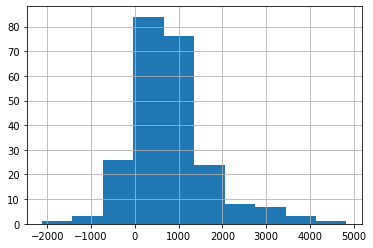

In [17]:
df_ideal.profit.hist()

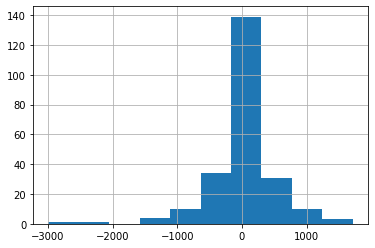

In [18]:
d_results['cvae'].profit.hist()

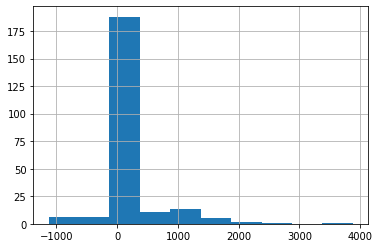

In [19]:
d_results['dvae'].profit.hist()

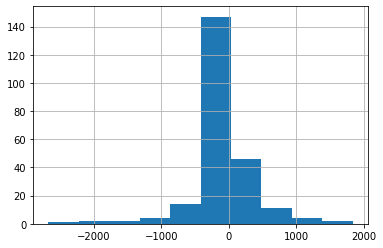

In [20]:
d_results['nn'].profit.hist()

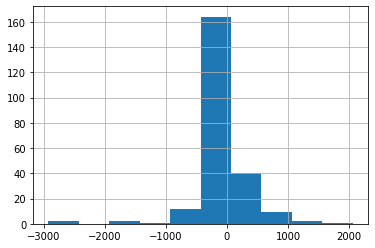

In [21]:
d_results['lvae'].profit.hist()

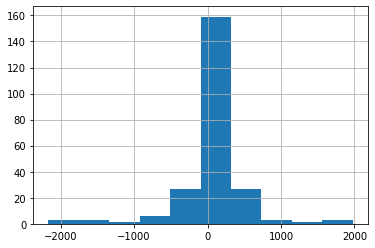

In [22]:
d_results['arima'].profit.hist()

In [21]:
### fix estimated high predictions for baseline and cvae
def fix_est_high(d_predictions):
    for ticker, dates in d_predictions.items():
        for date,prices in dates.items():
            index = d[ticker][d[ticker].date == date].index[0]
            prev_close = d[ticker].iloc[index-2]['close']
            d_predictions[ticker][date]['estimated_high']=prices['estimated_high']+prev_close
    return d_predictions
d_pred_nn = fix_est_high(dill.load(open('data/predictions_baseline_norm_input55.pkd','rb')))
#d_pred_cvae = fix_est_high(dill.load(open('data/predictions_cvae_norm_input55.pkd','rb')))

In [23]:
dill.dump(d_pred_nn,open('data/predictions_baseline_norm_input55.pkd','wb'))